In [542]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import clipboard
import base64
from io import BytesIO
from PIL import Image
from proxyattention.meta_utils import read_pickle, return_grouped_results

import seaborn as sns
pd.set_option('display.max_rows', 500)
# plt.switch_backend('Agg')
%matplotlib inline
sns.set_palette("Set2")


In [543]:
# !python result_aggregator.py

In [544]:
combined_df = read_pickle(fname = "./results/aggregated_runs.csv")[0]


In [545]:
combined_df.shape

(574, 39)

# Continue here

In [546]:
combined_df.head()

,index,proxy_step,Loss/Train,Acc/Train,global_run_count,Loss/Val,Acc/Val,experiment_name,image_size,batch_size,...,name_fn,writer,label_map,rev_label_map,num_classes,dataset_sizes,criterion,save_path,final_acc,Number_Chosen
0,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.003983,98.139999,40,0.16622,54.91,transform,224,16,...,<function get_parent_name at 0x7fdbe1e0ed40>,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/data/CODE/thesis_runs/proper_run...,54.91,NaN
1,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.018452,90.68,5,0.080843,67.860001,transform,224,16,...,<function get_parent_name at 0x7f10eb416d40>,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/data/CODE/thesis_runs/proper_run...,67.86,NaN
2,/media/eragon/data/CODE/thesis_runs/proper_run...,True,0.057611,74.150002,6,0.048799,77.209999,transform,224,16,...,<function get_parent_name at 0x7f10eb416d40>,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/data/CODE/thesis_runs/proper_run...,77.21,2068.0
3,/media/eragon/data/CODE/thesis_runs/proper_run...,False,0.008894,95.669998,15,0.07266,73.57,transform,224,16,...,<function get_parent_name at 0x7f10eb416d40>,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/data/CODE/thesis_runs/proper_run...,73.57,NaN
4,/media/eragon/data/CODE/thesis_runs/proper_run...,True,0.048916,78.370003,16,0.041322,80.949997,transform,224,16,...,<function get_parent_name at 0x7f10eb416d40>,<tensorboardX.writer.SummaryWriter object at 0...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),/media/eragon/data/CODE/thesis_runs/proper_run...,80.95,1731.0


In [547]:
combined_df.shape

(574, 39)

In [548]:
combined_df[combined_df["global_run_count"]!= "0"]["proxy_steps"].value_counts()

[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]    526
[20, 'p', 19]                           31
[40]                                    10
Name: proxy_steps, dtype: int64

In [549]:
combined_df["experiment_name"].value_counts()

transform    567
Name: experiment_name, dtype: int64

# Preprocess

In [569]:
def check_proxy(string): return "p" in str(string)

In [570]:
def calc_stats(values):
    return f"min: {values.min()} \nmax: {values.max()} \navg: {values.mean()}"

In [571]:
def convert_float(df, cols, totype= float):
    for col in cols:
        df[col] = df[col].astype(totype)

In [572]:
combined_df = combined_df.fillna(0)
# col to check for proxy
# combined_df["has_proxy"] = combined_df["proxy_steps"].apply(check_proxy)
# Fix naming
combined_df = combined_df.rename(columns={"Acc/Val":"accuracy", "proxy_steps":"step_schedule"})
# Fix types
convert_float(combined_df, ["change_subset_attention", "proxy_threshold", "accuracy"], float)
convert_float(combined_df, ["global_run_count"], int)
convert_float(combined_df, ["transfer_imagenet"], bool)

# ignore failed runs
combined_df = combined_df[combined_df["ds_name"]!="0"]
combined_df = combined_df[combined_df["global_run_count"]!=0]


In [573]:
combined_df["has_proxy"] = combined_df["step_schedule"].apply(check_proxy)

In [574]:
combined_df["global_run_count"].unique()

array([40,  5,  6, 15, 16, 25, 26, 35, 36, 20, 21, 22])

In [575]:
# combined_df = combined_df[combined_df["global_run_count"].astype(int) < 10]

In [576]:
combined_df.loc[combined_df["has_proxy"] == False, ["pixel_replacement_method", "gradient_method"]] = "baseline"

# Paper Results

## By Dataset

In [577]:
def return_grouped_results(
    df,
    group_cols,
    filter=None,
    map = None,
    index_cols=(["ds_name", ("accuracy")]),
    print_latex=False,
    save_latex=None,
    caption=None,
    label=None,
    format_size = None,
):
    df = df.copy()
    if map is not None:
        df[map[0]] = df[map[0]].map(map[1])
    if filter != None:
        df = df.reset_index()
        for key in filter.keys():
            df = df[df[key] == filter[key]]
    final_df = pd.DataFrame(
        df.groupby(group_cols, as_index=True).mean(numeric_only=True)["accuracy"]
    ).sort_values(index_cols, ascending=False)
    if print_latex == True:
        clipboard.copy(final_df.to_latex())
    if save_latex is not None:
        temp_latex = "\\begin{table}[H]\n"
        temp_latex += "\centering\n"
        if format_size is not None:
            temp_latex += "\\resizebox{" + str(format_size) +  "\\columnwidth}{!}{%\n"
        else:
            temp_latex += "\\resizebox{\\columnwidth}{!}{\n"
        temp_latex += final_df.to_latex()
        # temp_latex += "\end{tabular}%\\}"
        temp_latex += "}\n"
        temp_latex += "\caption{" + caption + "}" + "\n"
        temp_latex += "\label{" + str(label) + "}" + "\n"
        temp_latex += "\end{table}"
        with open(save_latex, "w+") as f:
            f.write(temp_latex)
    return final_df

In [581]:
return_grouped_results(combined_df, ["ds_name","model", "step_schedule"], map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"}), save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/summary_ds.tex", caption="Summary of results on different datasets", label="tab:summary_ds", format_size=.8)


/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_35276/984817673.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex()


accuracy
ds_name  model                step_schedule           
dogs     efficientnet_b0      Proxy          94.630158
                              No Proxy       85.605498
cifar100 vit_base_patch16_224 Proxy          75.651538
                              No Proxy       54.910000

In [582]:
combined_df["ds_name"].unique()

array(['cifar100', 0, 'dogs'], dtype=object)

In [583]:
return_grouped_results(combined_df, ["ds_name","model", "step_schedule"],filter={"ds_name" :"cifar100"}, map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"}))

accuracy
ds_name  model                step_schedule           
cifar100 vit_base_patch16_224 Proxy          75.651538
                              No Proxy       54.910000

 40%|████      | 2/5 [00:00<00:00,  9.44it/s]


ValueError: min() arg is an empty sequence

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

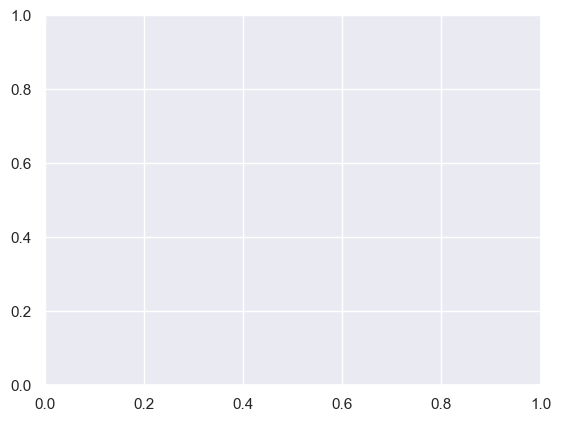

In [584]:
for dataset in tqdm(['dogs','cifar100', 'asl', 'plantdisease', 'caltech101']):
# for dataset in tqdm(['dogs','cifar100']):
    # print(dataset)
    temp_results = return_grouped_results(combined_df, ["ds_name","model", "step_schedule"],filter={"ds_name" :dataset}, map = ("step_schedule", {"[20, 'p', 19]":"Proxy", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"Proxy", "[40]":"No Proxy"}))
    plt.cla()
    plt.clf()
    fig, ax = plt.subplots()
    splot = sns.barplot(data=temp_results.reset_index(), x="model", y="accuracy", hue="step_schedule", errorbar="sd")
    # ax.bar_label(ax.containers[0])
    for g in splot.patches:
        splot.annotate(format(g.get_height(), '.1f')+ "%",
                (g.get_x() + g.get_width() / 2., g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
    plt.legend(loc='lower left')
    # break
    plt.savefig(f"/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/{dataset}_results.pdf", transparent=True)
    # except:
    #     pass

In [585]:
# Generate string for latex
ds_text = """\subsection{%s Results}
This section shows the accuracies per model for the %s dataset. The results are shown in Figure \\ref{fig:%s_results}. 
\\begin{figure}[H]
    \centering
    \includegraphics[width=1\\textwidth]{results/%s_results.pdf}
    \caption{Comparing Accuracies of models trained with and without Proxy Attention on the %s dataset}
    \label{fig:%s_results}
\end{figure}
""" 
full_string = ""
for ds in ['dogs','cifar100', 'caltech101','asl', 'plantdisease']:
    full_string += ds_text % tuple([ds.capitalize(),ds.capitalize(),ds, ds, ds.capitalize(), ds])
    full_string += "\n"
# print(full_string)
clipboard.copy(full_string)

# Group per step Schedule

In [587]:
temp_results = return_grouped_results(combined_df, ["ds_name", "step_schedule","model"], save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/schedule_resnet50.tex", caption="Accuracy grouped by Schedule for ResNet50", label="tab:gpschedulere", filter={"model":"efficientnet_b0"}, map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}))
temp_results

/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_35276/984817673.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex()


accuracy
ds_name step_schedule     model                     
dogs    5,p,9,p,9,p,9,p,4 efficientnet_b0  94.826179
        20,p,19           efficientnet_b0  90.876724
        No Proxy          efficientnet_b0  85.605498

<Figure size 640x480 with 0 Axes>

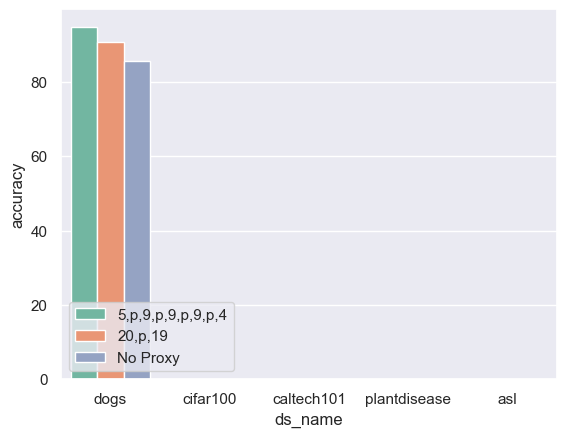

In [588]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
# splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy", hue="step_schedule", errorbar="sd", order=['dogs','cifar100', 'caltech101','plantdisease','asl'])
splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy", hue="step_schedule", errorbar="sd", order=['dogs','cifar100', 'caltech101','plantdisease','asl'])
# ax.bar_label(ax.containers[0])
# for g in splot.patches:
#     splot.annotate(format(g.get_height(), '.2f'),
#                 (g.get_x() + g.get_width() / 2., g.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 9),
#                 textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/schedule_resnet50.pdf", transparent=True)

# Results grouped by Proxy Threshold 

In [589]:
combined_df.columns

Index(['index', 'proxy_step', 'Loss/Train', 'Acc/Train', 'global_run_count',
       'Loss/Val', 'accuracy', 'experiment_name', 'image_size', 'batch_size',
       'enable_proxy_attention', 'transfer_imagenet', 'subset_images',
       'pixel_replacement_method', 'load_proxy_data', 'log_every', 'device',
       'dataset_info', 'main_run_dir', 'change_subset_attention', 'model',
       'proxy_image_weight', 'proxy_threshold', 'gradient_method', 'ds_name',
       'clear_every_step', 'step_schedule', 'fname_start', 'ds_path',
       'name_fn', 'writer', 'label_map', 'rev_label_map', 'num_classes',
       'dataset_sizes', 'criterion', 'save_path', 'final_acc', 'Number_Chosen',
       'has_proxy'],
      dtype='object')

In [590]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_threshold","model" ], 
save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/proxy_threshold_effnetb0.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Threshold for EfficientNetB0", label="tab:proxy_threshold", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"efficientnet_b0"})
temp_results

/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_35276/984817673.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex()


accuracy
ds_name proxy_threshold model                     
dogs    0.80            efficientnet_b0  94.620245
        0.85            efficientnet_b0  94.553233
        0.40            efficientnet_b0  94.447155
        0.10            efficientnet_b0  94.329463

<Figure size 640x480 with 0 Axes>

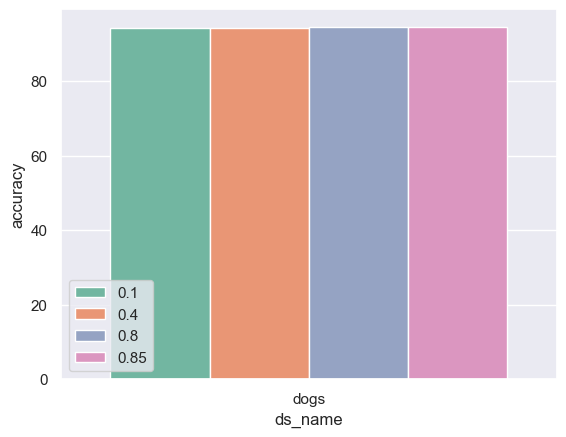

In [591]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy",  errorbar="sd", hue="proxy_threshold")
# ax.bar_label(ax.containers[0])
# for g in splot.patches:
#     splot.annotate(format(g.get_height(), '.2f'),
#                 (g.get_x() + g.get_width() / 2., g.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 9),
#                 textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/proxy_threshold_results.pdf", transparent=True)

# Grouped by proxy_image_weight

In [592]:
temp_results = return_grouped_results(combined_df, ["ds_name", "proxy_image_weight","model" ], 
save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/proxy_weight_effnetb0.tex", 
# save_latex = None,
caption="Accuracy grouped by Proxy Weight for EfficientNetB0", label="tab:proxy_weight", map = ("step_schedule", {"[20, 'p', 19]":"20,p,19", "[5, 'p', 9, 'p', 9, 'p', 9, 'p', 4]":"5,p,9,p,9,p,9,p,4", "[40]":"No Proxy"}),filter={"model":"efficientnet_b0"})
temp_results

/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_35276/984817673.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex()


accuracy
ds_name proxy_image_weight model                     
dogs    0.95               efficientnet_b0  94.615484
        0.8                efficientnet_b0  94.469923
        0.4                efficientnet_b0  94.455499
        0.1                efficientnet_b0  94.432822

<Figure size 640x480 with 0 Axes>

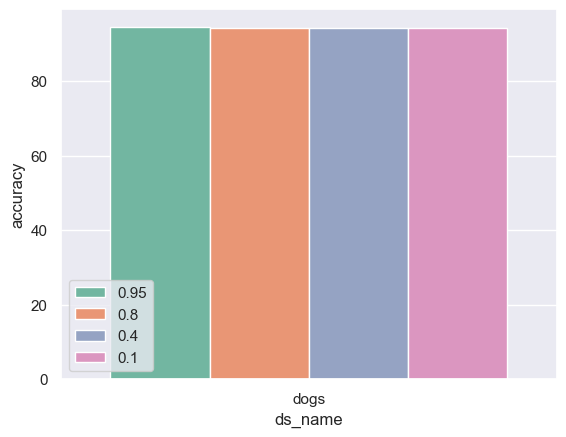

In [593]:
plt.cla()
plt.clf()
fig, ax = plt.subplots()
splot = sns.barplot(data=temp_results.reset_index(), x="ds_name", y="accuracy",  errorbar="sd", hue="proxy_image_weight", )
# ax.bar_label(ax.containers[0])
# for g in splot.patches:
#     splot.annotate(format(g.get_height(), '.2f'),
#                 (g.get_x() + g.get_width() / 2., g.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 9),
#                 textcoords = 'offset points')
plt.legend(loc='lower left')
plt.savefig(f"/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/proxy_weight_results.pdf", transparent=True)

# Extrasc

In [37]:
return_grouped_results(combined_df, ["experiment_name","ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], save_latex="/Users/eragon/Documents/CODE/Github/proxy_attention/writing/thesis/results/test.tex", caption="Test", label="test")

/var/folders/s2/psn1kzxd2_972xy94t5fr4cr0000gn/T/ipykernel_33629/1666816244.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  temp_latex += final_df.to_latex() + "\n"


accuracy
experiment_name ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
proxy_run       plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet18             0.2                 99.147778
                                                                                                                                                                    efficientnet_b0      0.2                 99.101112
                                                                                        [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 99.023333
                             baseline                 True              baseline        [40]                                0.80                    0.85            resnet18             0.2                 98.949997
                                                                                                                                                                    resnet50             0.2                 98.949997
                                                                                                                                                                    efficientnet_b0      0.2                 98.900002
                             blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet18             0.2                 98.826668
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 98.786666
                                                                                        [20, 'p', 19]                       0.80                    0.85            efficientnet_b0      0.2                 98.680000
                dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 95.497701
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 95.495351
hypers          dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0      0.8                 94.985541
                                                                                                                                                    0.10            efficientnet_b0      0.1                 94.911736
                                                                                                                                                    0.40            efficientnet_b0      0.95                94.890021
                                                                                                                                                                                         0.1                 94.845623
                                                                                                                                                    0.10            efficientnet_b0      0.8                 94.786770
                                                                                                                                                    0.40            efficientnet_b0      0.8                 94.782388
                                                                                                                         

In [15]:
return_grouped_results(combined_df, ["experiment_name","ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"])

accuracy
experiment_name ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
proxy_run       plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet18             0.2                 99.147778
                                                                                                                                                                    efficientnet_b0      0.2                 99.101112
                                                                                        [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 99.023333
                             baseline                 True              baseline        [40]                                0.80                    0.85            resnet18             0.2                 98.949997
                                                                                                                                                                    resnet50             0.2                 98.949997
                                                                                                                                                                    efficientnet_b0      0.2                 98.900002
                             blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet18             0.2                 98.826668
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 98.786666
                                                                                        [20, 'p', 19]                       0.80                    0.85            efficientnet_b0      0.2                 98.680000
                dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85            resnet50             0.2                 95.497701
                                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            resnet50             0.2                 95.495351
hypers          dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0      0.8                 94.985541
                                                                                                                                                    0.10            efficientnet_b0      0.1                 94.911736
                                                                                                                                                    0.40            efficientnet_b0      0.95                94.890021
                                                                                                                                                                                         0.1                 94.845623
                                                                                                                                                    0.10            efficientnet_b0      0.8                 94.786770
                                                                                                                                                    0.40            efficientnet_b0      0.8                 94.782388
                                                                                                                         

In [30]:

return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter={"experiment_name": "transform"})

accuracy
ds_name pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model                proxy_image_weight           
dogs    blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.80            vit_base_patch16_224 0.1                 86.055481
                                                                                                                               0.40            vit_base_patch16_224 0.1                 84.646194
                                                                                                                               0.10            vit_base_patch16_224 0.1                 83.396380
                                                                   [20, 'p', 19]                       0.8                     0.80            vit_base_patch16_224 0.1                 77.851952
                                                                                                                               0.10            vit_base_patch16_224 0.1                 77.555257
                                                                                                                               0.40            vit_base_patch16_224 0.1                 76.939624
        baseline                 True              baseline        [40]                                0.8                     0.10            vit_base_patch16_224 0.1                 71.562080
                                                                                                                               0.85            vit_base_patch16_224 0.1                 66.777924
                                                                                                                               0.80            vit_base_patch16_224 0.1                 65.242546
                                                                                                                               0.40            vit_base_patch16_224 0.1                 60.703159

In [31]:
return_grouped_results(combined_df, ["ds_name","model", "gradient_method", "step_schedule", "change_subset_attention"])

accuracy
ds_name      model                gradient_method step_schedule                       change_subset_attention           
plantdisease resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     99.147778
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     99.101112
             resnet50             gradcamplusplus [20, 'p', 19]                       0.80                     99.023333
             resnet18             baseline        [40]                                0.80                     98.949997
             resnet50             baseline        [40]                                0.80                     98.949997
             efficientnet_b0      baseline        [40]                                0.80                     98.900002
             resnet18             gradcamplusplus [20, 'p', 19]                       0.80                     98.826668
             resnet50             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     98.786666
             efficientnet_b0      gradcamplusplus [20, 'p', 19]                       0.80                     98.680000
dogs         resnet50             gradcamplusplus [20, 'p', 19]                       0.80                     95.497701
                                                  [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     95.495351
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                     94.672288
                                                                                      0.80                     93.442382
                                                                                      0.95                     93.339572
             resnet50             baseline        [40]                                0.80                     92.011574
             efficientnet_b0      gradcamplusplus [20, 'p', 19]                       0.80                     91.410772
             resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     87.411429
                                  gradcam         [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     86.384286
             efficientnet_b0      baseline        [40]                                0.80                     85.825546
             vit_base_patch16_224 gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     84.569055
             resnet18             gradcam         [20, 'p', 19]                       0.80                     80.473335
             vit_base_patch16_224 gradcamplusplus [20, 'p', 19]                       0.80                     77.448944
             resnet18             baseline        [40]                                0.80                     71.414997
             vit_base_patch16_224 baseline        [40]                                0.80                     66.071427
cifar100     resnet50             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     83.106666
                                                  [20, 'p', 19]                       0.80                     82.090001
             efficientnet_b0      gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     81.665000
                                                  [20, 'p', 19]                       0.80                     79.037500
             resnet50             baseline        [40]                                0.80                     78.699997
             resnet18             gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                     76.778000
                                                  [20, 'p', 19]                       0.80                     75.559998
             efficientnet_b0      baseline        [40]                                0.80                     75.22000

In [43]:
return_grouped_results(combined_df, ["ds_name", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter = { "ds_name":"plantdisease"})

accuracy
ds_name      transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model           proxy_image_weight           
plantdisease True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.85            resnet18        0.2                 99.147778
                                                                                                                           efficientnet_b0 0.2                 99.101112
                                               [20, 'p', 19]                       0.8                     0.85            resnet50        0.2                 99.023333
                               baseline        [40]                                0.8                     0.85            resnet18        0.2                 98.949997
                                                                                                                           resnet50        0.2                 98.949997
                                                                                                                           efficientnet_b0 0.2                 98.900002
                               gradcamplusplus [20, 'p', 19]                       0.8                     0.85            resnet18        0.2                 98.826668
                                               [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.8                     0.85            resnet50        0.2                 98.786666
                                               [20, 'p', 19]                       0.8                     0.85            efficientnet_b0 0.2                 98.680000

In [44]:
return_grouped_results(combined_df, ["ds_name", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold", "model", "proxy_image_weight"], filter = {"model":"efficientnet_b0"})

accuracy
ds_name      transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold model           proxy_image_weight           
plantdisease True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85            efficientnet_b0 0.2                 99.101112
                               baseline        [40]                                0.80                    0.85            efficientnet_b0 0.2                 98.900002
                               gradcamplusplus [20, 'p', 19]                       0.80                    0.85            efficientnet_b0 0.2                 98.680000
dogs         True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.80            efficientnet_b0 0.8                 94.985541
                                                                                                           0.10            efficientnet_b0 0.1                 94.911736
                                                                                                           0.40            efficientnet_b0 0.95                94.890021
                                                                                                                                           0.1                 94.845623
                                                                                                           0.10            efficientnet_b0 0.8                 94.786770
                                                                                                           0.40            efficientnet_b0 0.8                 94.782388
                                                                                                           0.85            efficientnet_b0 0.4                 94.762321
                                                                                                           0.10            efficientnet_b0 0.4                 94.737558
                                                                                                           0.80            efficientnet_b0 0.1                 94.723004
                                                                                                           0.85            efficientnet_b0 0.1                 94.658141
                                                                                                                                           0.8                 94.612412
                                                                                                           0.10            efficientnet_b0 0.95                94.565847
                                                                                                           0.80            efficientnet_b0 0.4                 94.493133
                                                                                                           0.40            efficientnet_b0 0.4                 94.491127
                                                                                                           0.80            efficientnet_b0 0.95                94.342921
                                                                                   0.80                    0.10            efficientnet_b0 0.1                 94.259889
                                                                                   0.20                    0.85            efficientnet_b0 0.95                94.168065
                                                                                   0.80                    0.40            efficientnet_b0 0.1                 94.059174
                                                                                                           0.80            efficientnet_b0 0.1                 93.934564
                                                                                                        

In [46]:

return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "change_subset_attention", "proxy_threshold"], filter = { "model":"efficientnet_b0", "has_proxy":True,})

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       change_subset_attention proxy_threshold           
plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             99.101112
                                                                        [20, 'p', 19]                       0.80                    0.85             98.680000
dogs         blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.20                    0.40             94.752290
                                                                                                                                    0.10             94.750478
                                                                                                                                    0.80             94.636150
                                                                                                                                    0.85             94.550235
                                                                                                            0.95                    0.10             93.690255
                                                                                                            0.80                    0.85             93.499807
                                                                                                                                    0.10             93.437621
                                                                                                            0.95                    0.40             93.428386
                                                                                                            0.80                    0.80             93.428107
                                                                                                                                    0.40             93.389638
                                                                                                            0.95                    0.80             93.363819
                                                                                                                                    0.85             92.817858
                                                                        [20, 'p', 19]                       0.80                    0.85             91.410772
cifar100     blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             81.665000
                                                                        [20, 'p', 19]                       0.80                    0.85             79.037500
caltech101   blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             97.773901
                                                                        [20, 'p', 19]                       0.80                    0.85             96.697289
asl          blended                  True              gradcamplusplus [20, 'p', 19]                       0.80                    0.85             99.903330
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.80                    0.85             99.844443

In [47]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "model"])

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method step_schedule                       model                          
plantdisease blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              99.147778
                                                                                                            efficientnet_b0       99.101112
                                                                        [20, 'p', 19]                       resnet50              99.023333
             baseline                 True              baseline        [40]                                resnet18              98.949997
                                                                                                            resnet50              98.949997
                                                                                                            efficientnet_b0       98.900002
             blended                  True              gradcamplusplus [20, 'p', 19]                       resnet18              98.826668
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              98.786666
                                                                        [20, 'p', 19]                       efficientnet_b0       98.680000
dogs         blended                  True              gradcamplusplus [20, 'p', 19]                       resnet50              95.497701
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              95.495351
                                                                                                            efficientnet_b0       93.905352
             baseline                 True              baseline        [40]                                resnet50              92.011574
             blended                  True              gradcamplusplus [20, 'p', 19]                       efficientnet_b0       91.410772
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              87.411429
                                                        gradcam         [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet18              86.384286
             baseline                 True              baseline        [40]                                efficientnet_b0       85.825546
             blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] vit_base_patch16_224  84.569055
                                                        gradcam         [20, 'p', 19]                       resnet18              80.473335
                                                        gradcamplusplus [20, 'p', 19]                       vit_base_patch16_224  77.448944
             baseline                 True              baseline        [40]                                resnet18              71.414997
                                                                                                            vit_base_patch16_224  66.071427
cifar100     blended                  True              gradcamplusplus [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] resnet50              83.106666
                                                                        [20, 'p', 19]                       resnet50              82.090001
                                                                        [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] efficientnet_b0       81.665000
                                                                        [20, 'p', 19]                       efficientnet_b0       79.037500
             baseline                 True              baseline        [40]                                resnet50              78.699997
             blended                  True              gradcamplusplus

In [49]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "change_subset_attention", "step_schedule", "proxy_image_weight",  "model", "global_run_count"])

accuracy
ds_name      pixel_replacement_method transfer_imagenet gradient_method change_subset_attention step_schedule                       proxy_image_weight model                global_run_count            
plantdisease blended                  True              gradcamplusplus 0.80                    [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                resnet50             40                 99.820000
                                                                                                                                                       efficientnet_b0      35                 99.730003
                                                                                                                                                       resnet18             40                 99.650002
                                                                                                                                                                            25                 99.580002
                                                                                                                                                                            35                 99.519997
                                                                                                                                                       efficientnet_b0      25                 99.510002
                                                                                                                                                                            15                 99.500000
                                                                                                                                                                            40                 99.449997
                                                                                                                                                       resnet18             15                 99.360001
                                                                                                                                                                            26                 99.339996
                                                                                                                                                       resnet50             25                 99.339996
                                                                                                                                                                            35                 99.330002
                                                                                                [20, 'p', 19]                       0.2                resnet18             40                 99.309998
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                efficientnet_b0      36                 99.239998
                                                                                                [20, 'p', 19]                       0.2                resnet50             40                 99.180000
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                resnet50             26                 99.139999
                                                                                                [20, 'p', 19]                       0.2                resnet50             21                 99.089996
                                                                                                [5, 'p', 9, 'p', 9, 'p', 9, 'p', 4] 0.2                efficientnet_b0      16                 99.040001
                                                                                                [20, 'p', 19]                       0.2                efficientnet_b0      